In [100]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
pd.set_option('display.max_rows', 1000) 

df = pd.read_csv('ivf_data.csv') 

# converts valid date entries to date, changes non-valid entries (. and nan) to NaT 
df["DATE"] = pd.to_datetime(df["DATE"], infer_datetime_format=True, errors='coerce') 

 
df = df.iloc[0:314,:] 

In [5]:
df.head()

,NUM,DATE,SAMPLE,REPLICATE,ANIMAL,BATCH,SUB_1_RP,SUB_2_H,SUB_3_LS,SUB_4_LP,...,LIN,MOTILE_PCT,PROGRESSIVE_PCT,RAPID_PCT,MEDIUM_PCT,SLOW_PCT,STATIC_PCT,CLIV,BLAST_D8,CELLS_COUNT
0,1.0,2015-07-16,135,26,PANDIAH,1305,26.32,15.76,21.64,36.29,...,44.0,45.0,37.0,44.0,1.0,6.0,49.0,82.716,33.333,188.750
1,2.0,2015-08-21,180,33,PANDIAH,1305,26.32,15.76,21.64,36.29,...,48.0,74.0,60.0,70.0,4.0,9.0,17.0,79.012,16.049,.
2,3.0,2015-08-28,191,34,PANDIAH,1305,26.32,15.76,21.64,36.29,...,47.0,41.0,30.0,37.0,3.0,26.0,34.0,76.923,20.253,184.500
3,4.0,2015-09-15,205,36,PANDIAH,130503,26.32,15.76,21.64,36.29,...,69.0,50.0,15.0,18.0,31.0,37.0,13.0,77.027,27.027,.
4,5.0,2015-10-01,227,38,PANDIAH,130503,26.32,15.76,21.64,36.29,...,51.0,63.0,54.0,59.0,4.0,16.0,22.0,76.829,39.024,169.500


In [25]:
df.RAPID_PCT.value_counts().sort_index()

0.0     6
1.0     3
3.0     1
5.0     1
7.0     2
       ..
74.0    4
78.0    4
80.0    3
81.0    2
83.0    2
Name: RAPID_PCT, Length: 69, dtype: int64

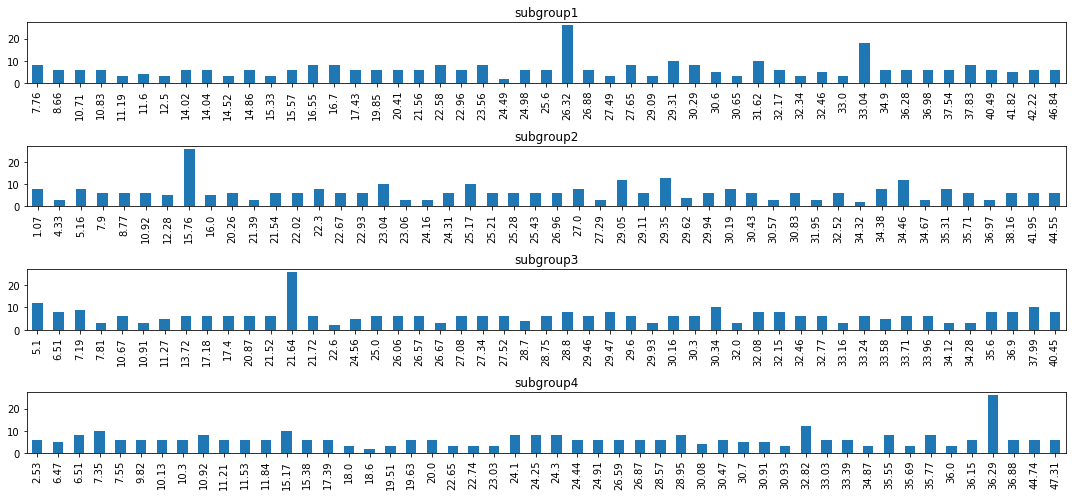

In [21]:
sub1 = df.SUB_1_RP.value_counts().sort_index()
sub2 = df.SUB_2_H.value_counts().sort_index()
sub3 = df.SUB_3_LS.value_counts().sort_index()
sub4 = df.SUB_4_LP.value_counts().sort_index()

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,7))
sub1.plot.bar(ax=ax1)
ax1.set_title("subgroup1")
sub2.plot.bar(ax=ax2)
ax2.set_title("subgroup2")
sub3.plot.bar(ax=ax3)
ax3.set_title("subgroup3")
sub4.plot.bar(ax=ax4)
ax4.set_title("subgroup4")

fig.tight_layout()

In [43]:
df_2 = df.loc[:,["MOTILE_PCT"]]
df_2["AI"] = df.loc[:,["AI"]]
blast = pd.to_numeric(df["BLAST_D8"],errors='coerce')
new.loc[blast > 25, "class"] = 1
df_2.loc[blast < 25, "class"] = -1

In [104]:
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

class SVM:
    def fit(self, X, y):
        n_samples, n_features = X.shape
# P = X^T X
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
# q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
# A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
# b = 0 
        b = cvxopt.matrix(0.0)
# -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
# 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
# Lagrange multipliers
        a = np.ravel(solution['x'])
# Lagrange have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
# Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)
# Weights
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        
    def project(self, X):
        return np.dot(X, self.w) + self.b
    
    
    def predict(self, X):
        return np.sign(self.project(X))

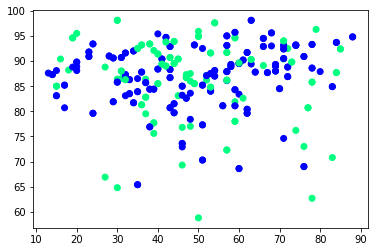

In [130]:
motile = pd.to_numeric(df["MOTILE_PCT"],errors='coerce').values.astype(float)
AI = pd.to_numeric(df["AI"],errors='coerce').values.astype(float)
X = np.vstack((motile, AI)).T
y = pd.to_numeric(df["BLAST_D8"],errors='coerce')
y[y > 25] = 100
y[y <= 25] = -1
y[y == 100] = 1
forasec = np.vstack((X[:,0],X[:,1],y)).T
forasec = forasec[~np.isnan(forasec).any(axis=1)]
X = forasec[:,0:2]
y = forasec[:,-1]
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [108]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [132]:
svm = SVM()
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -2.1090e+02 -5.0193e+02  3e+02  7e-15  2e+00
 1: -4.4994e+02 -4.5617e+02  6e+00  6e-15  1e+00
 2: -3.3092e+04 -3.3097e+04  5e+00  1e-12  1e+00
 3: -8.6563e+07 -8.6571e+07  8e+03  2e-09  1e+00
Terminated (singular KKT matrix).


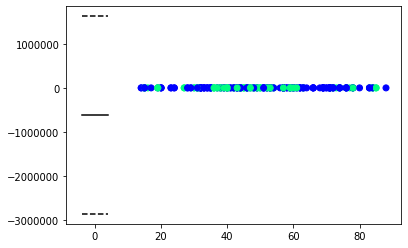

In [133]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
# w.x + b = 0
a0 = -4; a1 = f(a0, svm.w, svm.b)
b0 = 4; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')
# w.x + b = 1
a0 = -4; a1 = f(a0, svm.w, svm.b, 1)
b0 = 4; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')
# w.x + b = -1
a0 = -4; a1 = f(a0, svm.w, svm.b, -1)
b0 = 4; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

In [ ]:
df_2 = df.loc[:,["MOTILE_PCT"]]
df_2["AI"] = df.loc[:,["AI"]]
blast = pd.to_numeric(df["BLAST_D8"],errors='coerce')
new.loc[blast > 25, "class"] = 1
df_2.loc[blast < 25, "class"] = -1